In [1]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.metrics import accuracy_score, classification_report

# # Load the datasets
# clinical_data = pd.read_csv('datasets/clinical_dataset.csv')
# lifestyle_data = pd.read_csv('datasets/lifestyle_dataset.csv')

# # Preprocessing the lifestyle dataset by dropping the output column
# Xlifestyle = lifestyle_data.drop('Heart Attack Risk', axis=1)
# Ylifestyle = lifestyle_data['Heart Attack Risk']

# # Preprocessing the clinical dataset by dropping the output column
# Xclinical = clinical_data.drop('output', axis=1)
# Yclinical = clinical_data['output']

# # Convert categorical columns to numeric using one-hot encoding before splitting
# Xlifestyle_encoded = pd.get_dummies(Xlifestyle, drop_first=True)
# Xclinical_encoded = pd.get_dummies(Xclinical, drop_first=True)

New preprocessed data 

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.compose import ColumnTransformer

# Load data
clinical_data = pd.read_csv('datasets/clinical_dataset.csv')
lifestyle_data = pd.read_csv('datasets/lifestyle_dataset.csv')

# View basic information
print(clinical_data.head())
print(lifestyle_data.head())

#Dropping more columns from lfestyle dataset
columns_to_remove = ['Hemisphere', 'Patient ID', 'Income', 'Continent', 'Country']
lifestyle_data = lifestyle_data.drop(columns=columns_to_remove)

print(lifestyle_data.head())


# Preprocessing the lifestyle dataset by dropping the output column
Xlifestyle = lifestyle_data.drop('Heart Attack Risk', axis=1)
Ylifestyle = lifestyle_data['Heart Attack Risk']

# Checking the column names to make sure 'Sex' exists
print(Xlifestyle.columns)

# Identify categorical columns 
categorical_columns = ['Sex']

# Create a column transformer for handling both categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), Xlifestyle.select_dtypes(include=['float64', 'int64']).columns),  # Numerical columns
        ('cat', OneHotEncoder(), categorical_columns)  # Categorical columns
    ])

# Fit the preprocessor and transform the data
Xlifestyle_encoded = preprocessor.fit_transform(Xlifestyle)

# Now you can proceed with your ML model, e.g., splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(Xlifestyle_encoded, Ylifestyle, test_size=0.2, random_state=42)

# Check the shape of the scaled and transformed dataset
print(Xlifestyle_encoded.shape)

# Preprocessing the clinical dataset by dropping the output column
Xclinical_encoded = clinical_data.drop('output', axis=1)
Yclinical = clinical_data['output']


print(Xlifestyle.head())


   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  
  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1  

Approach 1: Principle Component Analysis 

When to use: PCA is suitable when you have numerical data and want to capture the most variance in fewer dimensions.
How it works: PCA transforms the data into new dimensions (principal components) that are linear combinations of the original features. The first few components capture the most variance in the data.
Benefit: This method is often useful when working with models like Logistic Regression or KNN, as it reduces the feature space and noise.

In [3]:

from sklearn.decomposition import PCA


scaler = StandardScaler()

# Scale lifestyle dataset
Xlife_scaled = scaler.fit_transform(Xlifestyle_encoded)

# Scale clinical dataset
Xclinical_scaled = scaler.fit_transform(Xclinical_encoded)

# Apply PCA to reduce dimensions to 10 components for lifestyle dataset
pca_life = PCA(n_components=10)
Xlife_pca = pca_life.fit_transform(Xlife_scaled)

# Apply PCA to reduce dimensions to 10 components for clinical dataset
pca_clinical = PCA(n_components=10)
Xclinical_pca = pca_clinical.fit_transform(Xclinical_scaled)


Check Balance between classes 

In [4]:
# Display class distribution for the lifestyle dataset
lifestyle_class_distribution = Ylifestyle.value_counts()
print("Lifestyle Dataset Class Distribution:")
print(lifestyle_class_distribution)

# Display class distribution for the clinical dataset
clinical_class_distribution = Yclinical.value_counts()
print("\nClinical Dataset Class Distribution:")
print(clinical_class_distribution)


Lifestyle Dataset Class Distribution:
Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64

Clinical Dataset Class Distribution:
output
1    165
0    138
Name: count, dtype: int64


There appears to be a significant imbalance between class 0 (5624) and class 1 (3139) for the lifestyle dataset 

Meanwhile for the clinical dataset there is a very minor imbalance 

I will represent these imbalances below

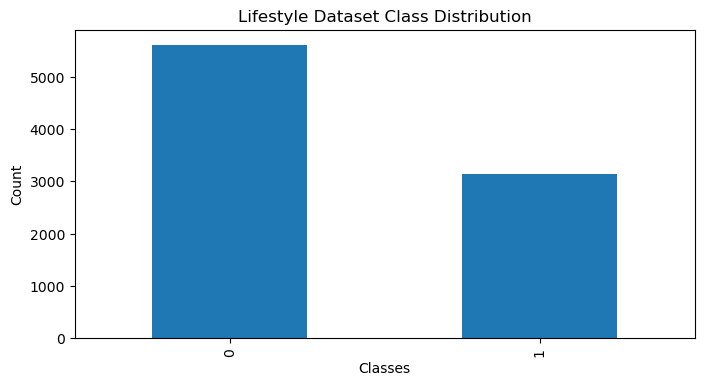

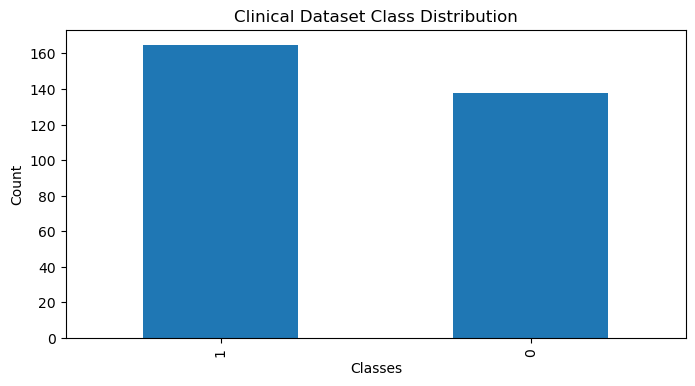

In [5]:
import matplotlib.pyplot as plt

# Visualize class distribution for the lifestyle dataset
plt.figure(figsize=(8, 4))
Ylifestyle.value_counts().plot(kind='bar')
plt.title('Lifestyle Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Visualize class distribution for the clinical dataset
plt.figure(figsize=(8, 4))
Yclinical.value_counts().plot(kind='bar')
plt.title('Clinical Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


In [6]:
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the lifestyle dataset into training and test sets
Xlife_train, Xlife_test, Ylife_train, Ylife_test = train_test_split(Xlife_pca, Ylifestyle, test_size=0.3, random_state=42)

# Apply SMOTE to the training set of the lifestyle dataset
smote = SMOTE(random_state=42)
Xlife_train_resampled, Ylife_train_resampled = smote.fit_resample(Xlife_train, Ylife_train)

# Define and train the MLP classifier for the lifestyle dataset
mlp_life = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_life.fit(Xlife_train_resampled, Ylife_train_resampled)

# Predictions and evaluation for MLP on the lifestyle test set
Ylife_pred_mlp = mlp_life.predict(Xlife_test)
print(f'MLP Accuracy (Lifestyle): {accuracy_score(Ylife_test, Ylife_pred_mlp)}')
print(classification_report(Ylife_test, Ylife_pred_mlp))

# Split the clinical dataset into training and test sets
Xclinical_train, Xclinical_test, Yclinical_train, Yclinical_test = train_test_split(Xclinical_pca, Yclinical, test_size=0.3, random_state=42)

# Apply SMOTE to the training set of the clinical dataset
Xclinical_train_resampled, Yclinical_train_resampled = smote.fit_resample(Xclinical_train, Yclinical_train)

# Define and train the MLP classifier for the clinical dataset
mlp_clinical = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_clinical.fit(Xclinical_train_resampled, Yclinical_train_resampled)

# Predictions and evaluation for MLP on the clinical test set
Yclinical_pred_mlp = mlp_clinical.predict(Xclinical_test)
print(f'MLP Accuracy (Clinical): {accuracy_score(Yclinical_test, Yclinical_pred_mlp)}')
print(classification_report(Yclinical_test, Yclinical_pred_mlp))


MLP Accuracy (Lifestyle): 0.5348041080258653
              precision    recall  f1-score   support

           0       0.65      0.60      0.62      1691
           1       0.37      0.41      0.39       938

    accuracy                           0.53      2629
   macro avg       0.51      0.51      0.51      2629
weighted avg       0.55      0.53      0.54      2629

MLP Accuracy (Clinical): 0.7802197802197802
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        41
           1       0.80      0.80      0.80        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.78      0.78      0.78        91



c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the lifestyle dataset into training and test sets
Xlife_train, Xlife_test, Ylife_train, Ylife_test = train_test_split(Xlife_pca, Ylifestyle, test_size=0.3, random_state=42)

# Apply SMOTE to the training set of the lifestyle dataset
smote = SMOTE(random_state=42)
Xlife_train_resampled, Ylife_train_resampled = smote.fit_resample(Xlife_train, Ylife_train)

# Define and train the SVC classifier for the lifestyle dataset
svc_life = SVC(kernel='linear', random_state=42)
svc_life.fit(Xlife_train_resampled, Ylife_train_resampled)

# Predictions and evaluation for SVC on the lifestyle test set
Ylife_pred_svc = svc_life.predict(Xlife_test)
print(f'SVC Accuracy (Lifestyle): {accuracy_score(Ylife_test, Ylife_pred_svc)}')
print(classification_report(Ylife_test, Ylife_pred_svc, zero_division=1))

# Split the clinical dataset into training and test sets
Xclinical_train, Xclinical_test, Yclinical_train, Yclinical_test = train_test_split(Xclinical_pca, Yclinical, test_size=0.3, random_state=42)

# Apply SMOTE to the training set of the clinical dataset
Xclinical_train_resampled, Yclinical_train_resampled = smote.fit_resample(Xclinical_train, Yclinical_train)

# Define and train the SVC classifier for the clinical dataset
svc_clinical = SVC(kernel='linear', random_state=42)
svc_clinical.fit(Xclinical_train_resampled, Yclinical_train_resampled)

# Predictions and evaluation for SVC on the clinical test set
Yclinical_pred_svc = svc_clinical.predict(Xclinical_test)
print(f'SVC Accuracy (Clinical): {accuracy_score(Yclinical_test, Yclinical_pred_svc)}')
print(classification_report(Yclinical_test, Yclinical_pred_svc, zero_division=1))


SVC Accuracy (Lifestyle): 0.4903004944845949
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1691
           1       0.36      0.53      0.43       938

    accuracy                           0.49      2629
   macro avg       0.50      0.50      0.48      2629
weighted avg       0.54      0.49      0.50      2629

SVC Accuracy (Clinical): 0.8461538461538461
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        41
           1       0.86      0.86      0.86        50

    accuracy                           0.85        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.85      0.85      0.85        91



Check the ROC curve and confusion matrix

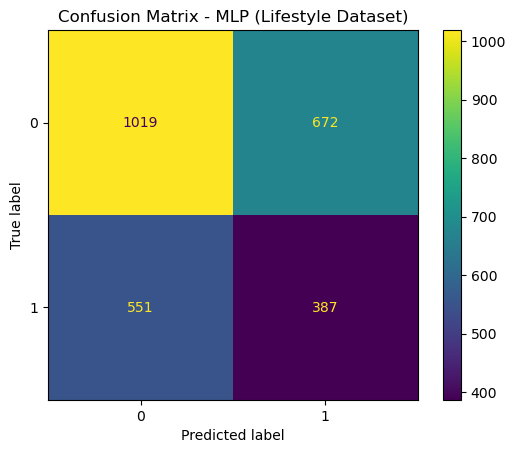

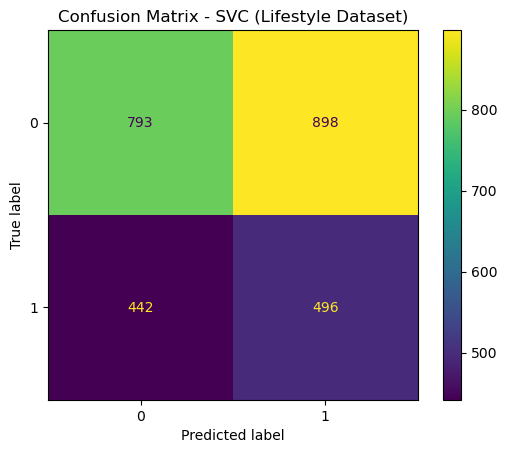

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for the MLP model on the lifestyle dataset
cm_mlp_life = confusion_matrix(Ylife_test, Ylife_pred_mlp)
disp_mlp_life = ConfusionMatrixDisplay(confusion_matrix=cm_mlp_life)
disp_mlp_life.plot()
plt.title("Confusion Matrix - MLP (Lifestyle Dataset)")
plt.show()

# Confusion matrix for the SVC model on the lifestyle dataset
cm_svc_life = confusion_matrix(Ylife_test, Ylife_pred_svc)
disp_svc_life = ConfusionMatrixDisplay(confusion_matrix=cm_svc_life)
disp_svc_life.plot()
plt.title("Confusion Matrix - SVC (Lifestyle Dataset)")
plt.show()


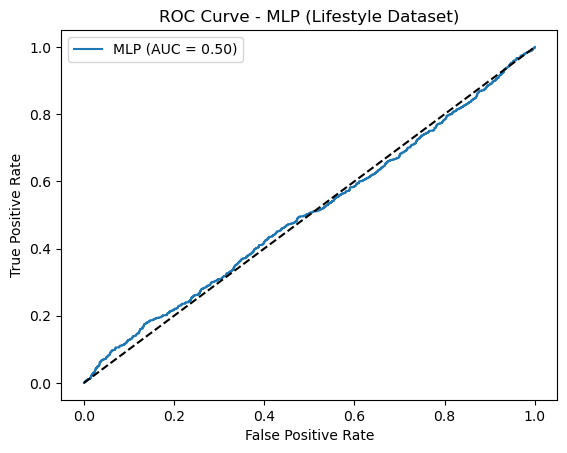

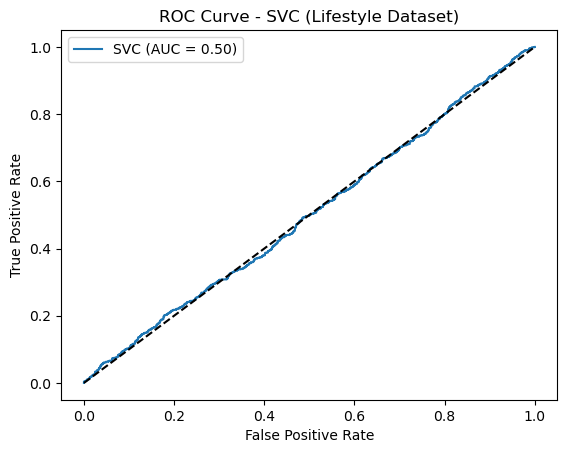

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# For the MLP model on the lifestyle dataset (use probabilities)
Ylife_mlp_probs = mlp_life.predict_proba(Xlife_test)[:, 1]  # Using the original test set
fpr_mlp, tpr_mlp, _ = roc_curve(Ylife_test, Ylife_mlp_probs)  # Using the original test set labels
roc_auc_mlp = roc_auc_score(Ylife_test, Ylife_mlp_probs)

# Plot the ROC curve for the MLP model
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP (Lifestyle Dataset)')
plt.legend()
plt.show()

# For the SVC model (use decision function for scores)
Ylife_svc_scores = svc_life.decision_function(Xlife_test)  # Using the original test set
fpr_svc, tpr_svc, _ = roc_curve(Ylife_test, Ylife_svc_scores)  # Using the original test set labels
roc_auc_svc = roc_auc_score(Ylife_test, Ylife_svc_scores)

# Plot the ROC curve for the SVC model
plt.figure()
plt.plot(fpr_svc, tpr_svc, label=f'SVC (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC (Lifestyle Dataset)')
plt.legend()
plt.show()


The ROC curves above are not very promising, the diagonal lines indicate that the model is no better than just random guessing

MLP cross validation 5 Fold


In [10]:
# # Cross-validation for MLP on the lifestyle dataset
# mlp_life_scores = cross_val_score(mlp_life, Xlife_pca, Ylifestyle, cv=5)
# print(f'MLP Cross-Validation Scores (Lifestyle): {mlp_life_scores}')
# print(f'MLP Average Score (Lifestyle): {mlp_life_scores.mean()}')

# # Cross-validation for MLP on the clinical dataset
# mlp_clinical_scores = cross_val_score(mlp_clinical, Xclinical_pca, Yclinical, cv=5)
# print(f'MLP Cross-Validation Scores (Clinical): {mlp_clinical_scores}')
# print(f'MLP Average Score (Clinical): {mlp_clinical_scores.mean()}')


MLP Cross-Validation Scores (Lifestyle): [0.59269823 0.6092413  0.60867085 0.60673516 0.61073059]
MLP Average Score (Lifestyle): 0.6056152271253193


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Cross-Validation Scores (Clinical): [0.90163934 0.7704918  0.86885246 0.81666667 0.68333333]
MLP Average Score (Clinical): 0.8081967213114755


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Average Score (Lifestyle): 0.6056152271253193
above code is commented out because it takes too long for bad results

SVC cross validation 5 Fold

In [11]:
# Cross-validation for SVC on the lifestyle dataset
svc_life_scores = cross_val_score(svc_life, Xlife_pca, Ylifestyle, cv=5)
print(f'SVC Cross-Validation Scores (Lifestyle): {svc_life_scores}')
print(f'SVC Average Score (Lifestyle): {svc_life_scores.mean()}')

# Cross-validation for SVC on the clinical dataset
svc_clinical_scores = cross_val_score(svc_clinical, Xclinical_pca, Yclinical, cv=5)
print(f'SVC Cross-Validation Scores (Clinical): {svc_clinical_scores}')
print(f'SVC Average Score (Clinical): {svc_clinical_scores.mean()}')


SVC Cross-Validation Scores (Lifestyle): [0.64175699 0.64175699 0.64175699 0.64212329 0.64155251]
SVC Average Score (Lifestyle): 0.6417893526296734
SVC Cross-Validation Scores (Clinical): [0.83606557 0.86885246 0.7704918  0.83333333 0.76666667]
SVC Average Score (Clinical): 0.8150819672131149


Lets try hyperparameter tuning

In [12]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Define hyperparameter grid for SVC
# svc_param_grid = {
#     'kernel': ['rbf', 'poly'],  # Trying both RBF and polynomial kernels
#     'C': [0.1, 1, 10],  # Regularization strength
#     'gamma': ['scale', 'auto']  # Kernel coefficient
# }

# # Apply GridSearchCV for SVC
# svc_grid = GridSearchCV(SVC(random_state=42), svc_param_grid, cv=5, verbose=2)
# svc_grid.fit(Xlife_train_resampled, Ylife_train_resampled)

# # Print the best hyperparameters for SVC
# print(f'Best SVC parameters: {svc_grid.best_params_}')

# # Evaluate the tuned SVC model on the test set
# Ylife_pred_svc_tuned = svc_grid.best_estimator_.predict(Xlife_test)
# print(f'Tuned SVC Accuracy (Lifestyle): {accuracy_score(Ylife_test, Ylife_pred_svc_tuned)}')
# print(classification_report(Ylife_test, Ylife_pred_svc_tuned))

# commented out because takes too long 


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define hyperparameter grid for SVC (clinical dataset)
svc_param_grid = {
    'kernel': ['rbf', 'poly'],  # Trying both RBF and polynomial kernels
    'C': [0.1, 1, 10],  # Regularization strength
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Apply GridSearchCV for SVC (clinical dataset)
svc_grid_clinical = GridSearchCV(SVC(random_state=42), svc_param_grid, cv=5, verbose=2)
svc_grid_clinical.fit(Xclinical_train_resampled, Yclinical_train_resampled)

# Print the best hyperparameters for SVC (clinical dataset)
print(f'Best SVC parameters (Clinical): {svc_grid_clinical.best_params_}')

# Evaluate the tuned SVC model on the clinical test set
Y_pred_svc_clinical_tuned = svc_grid_clinical.best_estimator_.predict(Xclinical_test)
print(f'Tuned SVC Accuracy (Clinical): {accuracy_score(Yclinical_test, Y_pred_svc_clinical_tuned)}')
print(classification_report(Yclinical_test, Y_pred_svc_clinical_tuned))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto

Hyper parameter tuning for MLP

In [14]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV

# # Define hyperparameter grid for MLP
# mlp_param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Different architectures
#     'activation': ['tanh', 'relu'],  # Activation functions
#     'solver': ['adam', 'sgd'],  # Different solvers for weight optimization
#     'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
# }

# # Apply GridSearchCV for MLP
# mlp_grid = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), mlp_param_grid, cv=5, verbose=2)
# mlp_grid.fit(Xlife_train_resampled, Ylife_train_resampled)

# # Print the best hyperparameters for MLP
# print(f'Best MLP parameters: {mlp_grid.best_params_}')

# # Evaluate the tuned MLP model on the test set
# Ylife_pred_mlp_tuned = mlp_grid.best_estimator_.predict(Xlife_test)
# print(f'Tuned MLP Accuracy (Lifestyle): {accuracy_score(Ylife_test, Ylife_pred_mlp_tuned)}')
# print(classification_report(Ylife_test, Ylife_pred_mlp_tuned))


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define hyperparameter grid for MLP (clinical dataset)
mlp_param_grid_clinical = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Different architectures
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Different solvers for weight optimization
    'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
}

# Apply GridSearchCV for MLP (clinical dataset)
mlp_grid_clinical = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), mlp_param_grid_clinical, cv=5, verbose=2)
mlp_grid_clinical.fit(Xclinical_train_resampled, Yclinical_train_resampled)

# Print the best hyperparameters for MLP (clinical dataset)
print(f'Best MLP parameters (Clinical): {mlp_grid_clinical.best_params_}')

# Evaluate the tuned MLP model on the clinical test set
Y_pred_mlp_clinical_tuned = mlp_grid_clinical.best_estimator_.predict(Xclinical_test)
print(f'Tuned MLP Accuracy (Clinical): {accuracy_score(Yclinical_test, Y_pred_mlp_clinical_tuned)}')
print(classification_report(Yclinical_test, Y_pred_mlp_clinical_tuned))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.3s
[CV] END activa

c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.0s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   0.1s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   0.2s


c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   0.3s
Best MLP parameters (Clinical): {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
Tuned MLP Accuracy (Clinical): 0.8351648351648352
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        41
           1       0.86      0.84      0.85        50

    accuracy                           0.84        91
   macro avg       0.83      0.83      0.83        91
weighted avg       0.84      0.84      0.84        91



c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


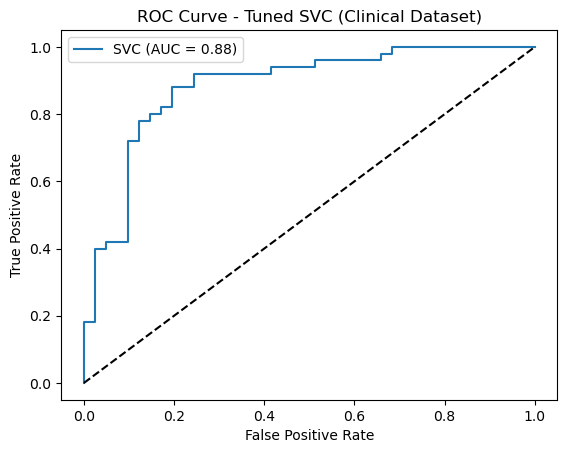

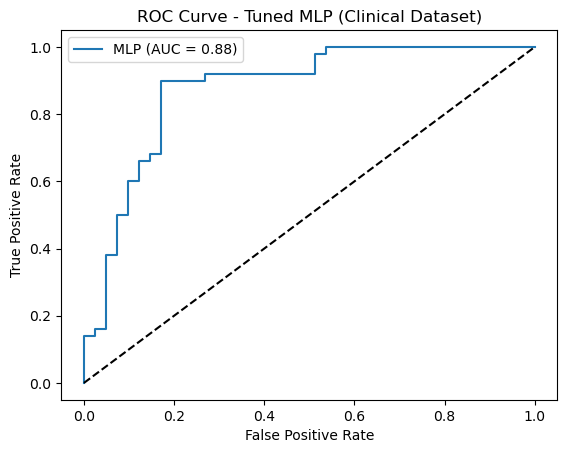

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# For the SVC model (use decision function for ROC)
Yclinical_svc_scores = svc_grid_clinical.best_estimator_.decision_function(Xclinical_test)
fpr_svc_clinical, tpr_svc_clinical, _ = roc_curve(Yclinical_test, Yclinical_svc_scores)
roc_auc_svc_clinical = roc_auc_score(Yclinical_test, Yclinical_svc_scores)

# Plot the ROC curve for the tuned SVC model (clinical dataset)
plt.figure()
plt.plot(fpr_svc_clinical, tpr_svc_clinical, label=f'SVC (AUC = {roc_auc_svc_clinical:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned SVC (Clinical Dataset)')
plt.legend()
plt.show()

# For the MLP model (use probabilities for ROC)
Yclinical_mlp_probs = mlp_grid_clinical.best_estimator_.predict_proba(Xclinical_test)[:, 1]
fpr_mlp_clinical, tpr_mlp_clinical, _ = roc_curve(Yclinical_test, Yclinical_mlp_probs)
roc_auc_mlp_clinical = roc_auc_score(Yclinical_test, Yclinical_mlp_probs)

# Plot the ROC curve for the tuned MLP model (clinical dataset)
plt.figure()
plt.plot(fpr_mlp_clinical, tpr_mlp_clinical, label=f'MLP (AUC = {roc_auc_mlp_clinical:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned MLP (Clinical Dataset)')
plt.legend()
plt.show()


Hyperparamter tuning yielded significant results from a ROC curve that was original just diagonal to one that is working. 


Suggested actions:

Try Hyperparameter tuning for random forest